In [ ]:
from IPython.core.display import HTML

HTML(
    """
    <style>

    .usecase-title, .usecase-duration, .usecase-section-header {
      padding-left: 15px;
      padding-bottom: 10px;
      padding-top: 10px;
      padding-right: 15px;
      background-color: #0f9295;
      color: #fff;
      }

    .usecase-title {
      font-size: 1.7em;
      font-weight: bold;
      }

    .usecase-authors, .usecase-level, .usecase-skill {
      padding-left: 15px;
      padding-bottom: 7px;
      padding-top: 7px;
      background-color: #baeaeb;
      font-size: 1.4em;
      color: #121212;
      }

    .usecase-level-skill {
      display: flex;
      }

    .usecase-level, .usecase-skill {
      width: 50%;
      }

    .usecase-duration, .usecase-skill {
      text-align: right;
      padding-right: 15px;
      padding-bottom: 8px;
      font-size: 1.4em;
      }

    .usecase-section-header {
      font-weight: bold;
      font-size: 1.5em;
      }

    .usecase-subsection-header, .usecase-subsection-blurb {
      font-weight: bold;
      font-size: 1.2em;
      color: #121212;
      }

    .usecase-subsection-blurb {
      font-size: 1em;
      font-style: italic;
      }

    </style>
    """)

### **Support Services**

**Authored by**: Thakoor Madhuvaishali

**Duration:Sprint 1 and 2 - Around 6 weeks

**Level:** Intermediate

**Pre-requisite Skills:** Python, Data analysis, data cleaning, data visualisation,

Scenario:

As a user in need of support services, I want to be able to easily find and locate nearby support services, so that I can access the help I need in a timely manner. I may be facing various challenges such as financial difficulties, mental health issues, or lack of access to transportation, and having easy access to support services can significantly improve my well-being and quality of life.

What this use case will teach you

At the end of this use case, you will:

*   Learn how to use Python to analyze and visualize data, enabling you to extract meaningful insights from datasets related to support services and public transport.
*   Gain experience in mapping and geocoding, allowing you to plot support service locations on a map and determine the nearest public transport options.
*   Understand how to integrate multiple datasets for analysis, helping you combine information about support services, bus stops, and tram tracks to create a comprehensive and user-friendly tool for accessing support services.

Introduction:

Accessing support services can be challenging for many individuals, especially those facing financial difficulties or transportation barriers. In such situations, having a centralized and easily accessible platform to locate support services can make a significant difference. The Support Services Locator website aims to bridge this gap by providing a user-friendly interface that allows users to search for support services based on their specific needs and location.

The Support Services use case aims to address the challenge of accessing support services for individuals in need, particularly those facing financial constraints or transportation difficulties. By creating a website with a map filter function, users can easily find nearby support services such as counseling, food assistance, and healthcare. The website will also display the nearest bus stop or tram station to help users reach their destination efficiently.

**DATASETS LIST:**
- Free and cheap support services, with opening hours, public transport, and parking options

This dataset contains information about various support services available to the community and includes details such as the name and address of each service, their opening hours, the availability of public transport options (e.g., bus stops, tram stations) near the location, and information about parking availability.

- Bus stops

This dataset contains information about the locations of bus stops in the area, including their geographic coordinates (latitude and longitude). This information is crucial for helping users navigate to their desired support service locations using public transport.

- Tram tracks

This dataset contains information about the tram tracks in the area, including their routes and stops. Tram tracks are another important aspect of public transport infrastructure that can help users plan their journeys to support service locations.








# **Part 1 - Import modules and fetch data from Open Data Melbourne**

---



In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Function that extracts the data from the JSON
def get_data(base, data_url, offset = 0):

    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    # if you need to extract more than 9900 records, enter the api key like below
    #result = requests.get(url + f'&apikey={API_KEY}')
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)

    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()

    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names

    next_url = None

    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']

    return [records_df, next_url, column_names]

In [ ]:
# Appends each set of data
def add_to_dataframe(dataframe, new_data):
    df = pd.concat([dataframe, new_data])
    return df

In [ ]:
# Extracts the data from the url to produce a pandas dataset
def extract_dataframe(dataset):
    df_new, url_next, column_names = get_data(base_url, dataset)
    df = pd.DataFrame(columns=column_names)
    while url_next != None:
        df_new, url_next, column_names = get_data(base_url, dataset, df.shape[0])
        df = add_to_dataframe(df, df_new)
        # This limits the dataset to only 9900 entries, should be removed if you want to import more data
        # To get more than 9900, enter the API key in the get data function
        if df.shape[0] == 9900:
            break
    return df

In [ ]:
# Base url for v2 api
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

# A filter at the end of the url
number_of_records = 100
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

# The generated url
# dataset_url = f'{base_url}{dataset}/{filters}'

In [ ]:
# Creating a dataframe for the support services
df = extract_dataframe("free-and-cheap-support-services-with-opening-hours-public-transport-and-parking-")


In [ ]:
#extracting data for the bus stops and tram tracks and creating the dataframes
df_bus_stop = extract_dataframe("bus-stops")
df_tram_tracks = extract_dataframe("tram-tracks")

# **Exploring and Cleaning of the support services dataset**

---



In [ ]:
df.head(20) # getthing an overview of the dataset

id                 timestamp  size  \
0   ffb55e9ec8257828aa5057ebfc22f5eb9f5d18d2  2022-11-13T10:02:12.681Z   764   
1   c6796c9abf80e8dfd45eec88b9b0a169c03f0b48  2022-11-13T10:02:12.681Z   839   
2   184866856a1e5cfb558bd0f314e79ba809c4c3cb  2022-11-13T10:02:12.681Z   790   
3   bd769f1c88b728a2987ec860f4ca0381ce7d8ed3  2022-11-13T10:02:12.681Z   586   
4   9da019f0c81bd00463c356930940e258cc16bf49  2022-11-13T10:02:12.681Z   960   
5   ba6a12d05c816ef7ce98d5de9dac7123927759d0  2022-11-13T10:02:12.681Z   567   
6   675fef59f085cc5ed54b5d73af21409277fa9dea  2022-11-13T10:02:12.681Z   446   
7   e5bfec0e7180e746ecf5c9fdcd16e4a124927a2e  2022-11-13T10:02:12.681Z   577   
8   af28916f2ea4de8ec829fbcfe7413039649a8997  2022-11-13T10:02:12.681Z   836   
9   645267fa734a80f4ce0699f011002401eb193b17  2022-11-13T10:02:12.681Z   726   
10  d195772e6ccd98ec483d5bdc46ec438209ace678  2022-11-13T10:02:12.681Z   935   
11  e11488133f78331761431809a8c0234cafa084de  2022-11-13T10:02:12.681Z   609   
12  76b9ffc20a0461558c39453facb5aceec4acccbc  2022-11-13T10:02:12.681Z   411   
13  70b83dea895ab4318e28975e386e608ce98aa447  2022-11-13T10:02:12.681Z   768   
14  d5ac8596d276e0248caa7e36503f2c63e61e19b9  2022-11-13T10:02:12.681Z  1093   
15  8e1cde3ddee716876e3483d5a754a0dc84231bb3  2022-11-13T10:02:12.681Z   946   
16  f6a4cd46a2099b5cc74b2e312b1f28a8869db5f0  2022-11-13T10:02:12.681Z   550   
17  3187b36ff47076a6ae4073e230f188939c34e39e  2022-11-13T10:02:12.681Z   424   
18  d4c8602247fc37273dd4d15ee8c16d0efa638724  2022-11-13T10:02:12.681Z  1538   
19  212aa0122c801840e867fa6caae724030a6048db  2022-11-13T10:02:12.681Z  1277   

                                                 name  \
0                                       Action Centre   
1                  Anglicare Victoria – Mission House   
2   Australian College of Optometry Outreach Services   
3            CatholicCare/St Mary of the Cross Centre   
4               Central City Community Health Service   
5                                          Centrelink   
6                                    Clarendon Clinic   
7                                            COHEALTH   
8                            Frontyard Youth Services   
9                                     Hanover Fitzroy   
10                    Inner Melbourne Community Legal   
11                                         Quin House   
12                        North West Outreach Service   
13                            Ozanam Community Centre   
14               Sacred Heart Mission’s Women’s House   
15                      Sacred Heart Mission’s Clinic   
16        Salvation Army – 24/7 Melbourne’s Road Home   
17                        St. Francis Pastoral Centre   
18                        St. Mary’s House of Welcome   
19                    TRAVELLERS AID - Spencer Street   

                                                 what  \
0   contraception, sexuality and gender issues, pr...   
1   Provides Emergency Relief to people living in ...   
2   Homeless Persons Eyecare Program, Supported Re...   
3   referral, drug education, counselling, group s...   
4   Outreach support services for people experienc...   
5   Centrelink is an Australian Government agency ...   
6   psychiatric services for people with serious m...   
7   broad range of allied health and counselling s...   
8   accommodation referral, centrelink, youth conn...   
9   The Assertive Outreach Team offers support to ...   
10        free legal information, advice and casework   
11  Quin House accommodates men over 18 years. The...   
12                         needle and syringe program   
13  breakfast – daily between 9.15 am - 10am\nlunc...   
14  The Women’s House is a safe drop-in centre for...   
15  provides natural and complementary therapies s...   
16  is an outreach program that seeks to search, l...   
17                                               None   
18  meals program, showers, information and referr...   
19  free assistance (bu

In [ ]:
df.info() # this will give us the number of rows and columns in the dataset for the support services

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 18
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     119 non-null    object 
 1   timestamp              119 non-null    object 
 2   size                   119 non-null    object 
 3   name                   118 non-null    object 
 4   what                   97 non-null     object 
 5   who                    27 non-null     object 
 6   address_1              17 non-null     object 
 7   address_2              90 non-null     object 
 8   suburb                 90 non-null     object 
 9   phone                  100 non-null    object 
 10  phone_2                4 non-null      object 
 11  free_call              27 non-null     object 
 12  email                  50 non-null     object 
 13  website                114 non-null    object 
 14  twitter                62 non-null     object 
 15  social_media

In [ ]:
#Find the missing values for the support services dataset
df.isnull().sum()


id                         0
timestamp                  0
size                       0
name                       1
what                      22
who                       92
address_1                102
address_2                 29
suburb                    29
phone                     19
phone_2                  115
free_call                 92
email                     69
website                    5
twitter                   57
social_media              58
monday                    31
tuesday                   31
wednesday                 31
thursday                  31
friday                    31
saturday                  32
sunday                    32
public_holidays           32
cost                     103
tram_routes               44
bus_routes               112
nearest_train_station     87
category_1                 1
category_2                 1
category_3                 1
category_4                 1
category_5                 1
category_6                 1
longitude     

In [ ]:
# Check for missing values in latitude and longitude columns
missing_lat = df['latitude'].isnull().sum()
missing_lon = df['longitude'].isnull().sum()

# Print the number of missing values
print(f"Missing latitude values: {missing_lat}")
print(f"Missing longitude values: {missing_lon}")

Missing latitude values: 30
Missing longitude values: 31


In [ ]:
#cleaning the datasets of missing values for latitude,longitude and name as these would be the crucial components for analysis
df = df.dropna(subset=['latitude', 'longitude', 'name'])

In [ ]:
df.head(20) # overview of the cleaned dataset

id                 timestamp  size  \
0   ffb55e9ec8257828aa5057ebfc22f5eb9f5d18d2  2022-11-13T10:02:12.681Z   764   
1   c6796c9abf80e8dfd45eec88b9b0a169c03f0b48  2022-11-13T10:02:12.681Z   839   
3   bd769f1c88b728a2987ec860f4ca0381ce7d8ed3  2022-11-13T10:02:12.681Z   586   
4   9da019f0c81bd00463c356930940e258cc16bf49  2022-11-13T10:02:12.681Z   960   
5   ba6a12d05c816ef7ce98d5de9dac7123927759d0  2022-11-13T10:02:12.681Z   567   
6   675fef59f085cc5ed54b5d73af21409277fa9dea  2022-11-13T10:02:12.681Z   446   
7   e5bfec0e7180e746ecf5c9fdcd16e4a124927a2e  2022-11-13T10:02:12.681Z   577   
8   af28916f2ea4de8ec829fbcfe7413039649a8997  2022-11-13T10:02:12.681Z   836   
9   645267fa734a80f4ce0699f011002401eb193b17  2022-11-13T10:02:12.681Z   726   
10  d195772e6ccd98ec483d5bdc46ec438209ace678  2022-11-13T10:02:12.681Z   935   
11  e11488133f78331761431809a8c0234cafa084de  2022-11-13T10:02:12.681Z   609   
13  70b83dea895ab4318e28975e386e608ce98aa447  2022-11-13T10:02:12.681Z   768   
14  d5ac8596d276e0248caa7e36503f2c63e61e19b9  2022-11-13T10:02:12.681Z  1093   
15  8e1cde3ddee716876e3483d5a754a0dc84231bb3  2022-11-13T10:02:12.681Z   946   
17  3187b36ff47076a6ae4073e230f188939c34e39e  2022-11-13T10:02:12.681Z   424   
18  d4c8602247fc37273dd4d15ee8c16d0efa638724  2022-11-13T10:02:12.681Z  1538   
19  212aa0122c801840e867fa6caae724030a6048db  2022-11-13T10:02:12.681Z  1277   
20  27650336ec99796ddd7f53a53740c79d1fdea9a2  2022-11-13T10:02:12.681Z   838   
21  89a54e1944a0b621bca55502f97568e2820b241d  2022-11-13T10:02:12.681Z   518   
22  7acb62ba53afcfbec9f742113183de7e70c699a1  2022-11-13T10:02:12.681Z  1027   

                                        name  \
0                              Action Centre   
1         Anglicare Victoria – Mission House   
3   CatholicCare/St Mary of the Cross Centre   
4      Central City Community Health Service   
5                                 Centrelink   
6                           Clarendon Clinic   
7                                   COHEALTH   
8                   Frontyard Youth Services   
9                            Hanover Fitzroy   
10           Inner Melbourne Community Legal   
11                                Quin House   
13                   Ozanam Community Centre   
14      Sacred Heart Mission’s Women’s House   
15             Sacred Heart Mission’s Clinic   
17               St. Francis Pastoral Centre   
18               St. Mary’s House of Welcome   
19           TRAVELLERS AID - Spencer Street   
20          TRAVELLERS AID - Flinders Street   
21         Victoria Police - Melbourne North   
22  Women’s Health Information Centre (WHIC)   

                                                 what  \
0   contraception, sexuality and gender issues, pr...   
1   Provides Emergency Relief to people living in ...   
3   referral, drug education, counselling, group s...   
4   Outreach support services for people experienc...   
5   Centrelink is an Australian Government agency ...   
6   psychiatric services for people with serious m...   
7   broad range of allied health and counselling s...   
8   accommodation referral, centrelink, youth conn...   
9   The Assertive Outreach Team offers support to ...   
10        free legal information, advice and casework   
11  Quin House accommodates men over 18 years. The...   
13  breakfast – daily between 9.15 am - 10am\nlunc...   
14  The Women’s House is a safe drop-in centre for...   
15  provides natural and complementary therapies s...   
17                                               None   
18  meals program, showers, information and referr...   
19  free assistance (buggy and personal guidance) ...   
20  Mobility Equipment Hire\nMedical Companion Ser...   
21  In case of an emergency or if you require imme...   
22  The Women’s Health Information Centre (WHIC) i...   

                                                  who  \
0                 Services are for under 25 year olds   
1   Assistance may be given to those liv

# **Visualising the support services**

In [ ]:
map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)  # Melbourne coordinates
for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(map)


In [ ]:
map

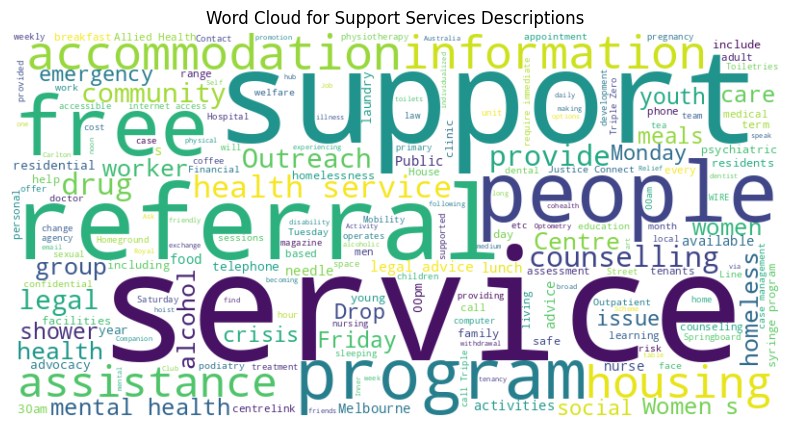

In [ ]:
#Visualisation of a  world cloud to help identify the most common keywords associated with the services provided by these support services
from wordcloud import WordCloud

# Extract the text descriptions from the "what" column
text = " ".join(df["what"].dropna().astype(str).tolist())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Support Services Descriptions")
plt.show()

As we can see from the word cloud above, some of the common words which would describe the type of support service being offered is accomodation, counselling, housing, homeless, women's, worker and drug which gives us an idea about the type of issues that these support services are targetting.

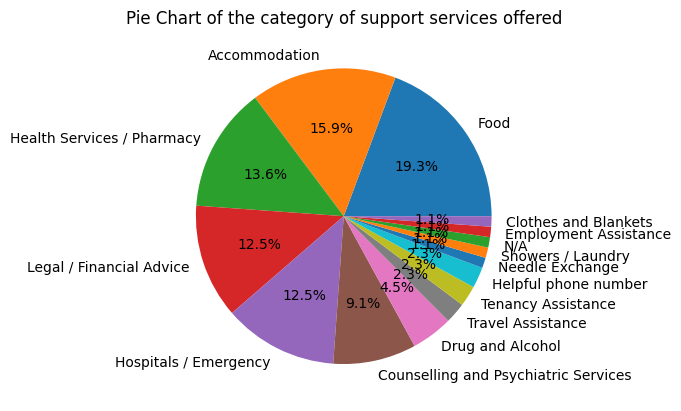

In [ ]:
import matplotlib.pyplot as plt

# Get the target groups from the "who" column
target_groups = df["category_1"].value_counts()

# Extract the group names and counts
group_names = target_groups.index.to_list()
group_counts = target_groups.to_list()

# Create a pie chart
plt.pie(group_counts, labels=group_names, autopct="%1.1f%%")
plt.title("Pie Chart of the category of support services offered")
plt.show()

From the pie chart above, we can see that the biggest categpries of support services offered is food wutg 19.3%, accomodation with 15.9% and health services  with 13.6%

# **Exploring the bus stops and tram tracks datasets**

In [ ]:
df_bus_stop.info() #information about the columns and values of the columns in the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 0 to 8
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           309 non-null    object 
 1   timestamp    309 non-null    object 
 2   size         309 non-null    object 
 3   lon          309 non-null    float64
 4   lat          309 non-null    float64
 5   type         309 non-null    object 
 6   coordinates  309 non-null    object 
 7   type         309 non-null    object 
 8   prop_id      309 non-null    object 
 9   addresspt1   309 non-null    float64
 10  addressp_1   309 non-null    object 
 11  asset_clas   309 non-null    object 
 12  asset_type   309 non-null    object 
 13  objectid     309 non-null    object 
 14  str_id       309 non-null    object 
 15  addresspt    309 non-null    object 
 16  asset_subt   0 non-null      object 
 17  model_desc   309 non-null    object 
 18  mcc_id       309 non-null    object 
 19  roadseg_id   30

In [ ]:
df_tram_tracks.info() #information about the columns and values of the columns in the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 645 entries, 0 to 44
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           645 non-null    object 
 1   timestamp    645 non-null    object 
 2   size         645 non-null    object 
 3   lon          645 non-null    float64
 4   lat          645 non-null    float64
 5   type         645 non-null    object 
 6   coordinates  645 non-null    object 
 7   type         645 non-null    object 
 8   descriptio   645 non-null    object 
 9   name         645 non-null    object 
dtypes: float64(2), object(8)
memory usage: 55.4+ KB


In [ ]:
#Find the missing values for the bus stops dataset
df_bus_stop.isnull().sum()

id               0
timestamp        0
size             0
lon              0
lat              0
type             0
coordinates      0
type             0
prop_id          0
addresspt1       0
addressp_1       0
asset_clas       0
asset_type       0
objectid         0
str_id           0
addresspt        0
asset_subt     309
model_desc       0
mcc_id           0
roadseg_id       0
descriptio       0
model_no         0
dtype: int64

In [ ]:
#Find the missing values for the tram tracks dataset
df_tram_tracks.isnull().sum()

id             0
timestamp      0
size           0
lon            0
lat            0
type           0
coordinates    0
type           0
descriptio     0
name           0
dtype: int64

Since there are no missing values for both datasets, there is no further data cleaning to be done

# **Visualising the bus stops and tram tracks on the map**

In [ ]:
# Add tram stop markers to the map
for index, row in df_tram_tracks.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='green'), popup=row['name']).add_to(map)

# Add bus stop markers to the map
for index, row in df_bus_stop.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='red'), popup=row['descriptio']).add_to(map)

In [ ]:
map


# **Finding the shortest distance route from the support service to the nearest bus stop or tram stop**

In [ ]:
from math import radians, sin, cos, sqrt, atan2


# Function to calculate distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = radians(lat1), radians(lon1), radians(lat2), radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    distance = r * c

    return distance

# Iterate over each support service and calculate the distance to the nearest bus stop
for index, service_row in df.iterrows():
    nearest_distance = float('inf')  # Initialize with a large value
    for stop_index, stop_row in df_bus_stop.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
    # Update the support service DataFrame with the nearest distance to a bus stop
    df.at[index, 'nearest_bus_stop_distance'] = nearest_distance

# Iterate over each support service and calculate the distance to the nearest tram stop
for index, service_row in df.iterrows():
    nearest_distance = float('inf')  # Initialize with a large value
    for stop_index, stop_row in df_tram_tracks.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
    # Update the support service DataFrame with the nearest distance to a tram
    # stop
    df.at[index, 'nearest_tram_track_distance'] = nearest_distance


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a map object
map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Add support service markers to the map
service_marker_cluster = MarkerCluster().add_to(map)
for index, service_row in df.iterrows():
    folium.Marker([service_row['latitude'], service_row['longitude']], popup=service_row['name']).add_to(service_marker_cluster)

# Add nearest bus stop markers to the map
bus_stop_marker_cluster = MarkerCluster().add_to(map)
for index, service_row in df.iterrows():
    nearest_distance = float('inf')
    nearest_bus_stop = None
    for stop_index, stop_row in df_bus_stop.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_bus_stop = stop_row
    if nearest_bus_stop is not None:
        folium.Marker([nearest_bus_stop['lat'], nearest_bus_stop['lon']],
                      popup=f"Nearest Bus Stop to {service_row['name']}",
                      icon=folium.Icon(color='green')).add_to(bus_stop_marker_cluster)


# Add nearest tram track markers to the map
tram_track_marker_cluster = MarkerCluster().add_to(map)
for index, service_row in df.iterrows():
    nearest_distance = float('inf')
    nearest_tram_track = None
    for stop_index, stop_row in df_tram_tracks.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_tram_track = stop_row
    if nearest_tram_track is not None:
        folium.Marker([nearest_tram_track['lat'], nearest_tram_track['lon']],
                      popup=f"Nearest Tram Track to {service_row['name']}",
                      icon=folium.Icon(color='red')).add_to(tram_track_marker_cluster)

# Display the map
map


This map displays all the support services and the nearest tram tracks and bus stops around them. By hovering on each support service or bus stop/tram track we can get an information of where they are situated and what is the closest tram track or bus stop to that support service. They can be differentiated by the diferent colours as well.

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a map object
map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Add support service markers to the map
service_marker_cluster = MarkerCluster(name='Support Services').add_to(map)
for index, service_row in df.iterrows():
    folium.Marker([service_row['lat'], service_row['lon']],
                  popup=service_row['name'],
                  icon=folium.Icon(color='blue', icon='info-sign')).add_to(service_marker_cluster)

# Add nearest bus stop markers and paths to the map
bus_stop_marker_cluster = MarkerCluster(name='Bus Stops').add_to(map)
for index, service_row in df.iterrows():
    nearest_distance = float('inf')
    nearest_bus_stop = None
    for stop_index, stop_row in df_bus_stop.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_bus_stop = stop_row
    if nearest_bus_stop is not None:
        folium.Marker([nearest_bus_stop['lat'], nearest_bus_stop['lon']],
                      popup=f"Nearest Bus Stop to {service_row['name']}",
                      icon=folium.Icon(color='green', icon='bus')).add_to(bus_stop_marker_cluster)

        # Draw a path from support service to bus stop
        points = [[service_row['lat'], service_row['lon']],
                  [nearest_bus_stop['lat'], nearest_bus_stop['lon']]]
        folium.PolyLine(locations=points, color='red', weight=2.5, opacity=1).add_to(map)

# Add nearest tram track markers and paths to the map
tram_track_marker_cluster = MarkerCluster(name='Tram Tracks').add_to(map)
for index, service_row in df.iterrows():
    nearest_distance = float('inf')
    nearest_tram_track = None
    for stop_index, stop_row in df_tram_tracks.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_tram_track = stop_row
    if nearest_tram_track is not None:
        folium.Marker([nearest_tram_track['lat'], nearest_tram_track['lon']],
                      popup=f"Nearest Tram Track to {service_row['name']}",
                      icon=folium.Icon(color='purple', icon='train')).add_to(tram_track_marker_cluster)

        # Draw a path from support service to tram track
        points = [[service_row['lat'], service_row['lon']],
                  [nearest_tram_track['lat'], nearest_tram_track['lon']]]
        folium.PolyLine(locations=points, color='blue', weight=2.5, opacity=1).add_to(map)

# Add layer control to toggle markers and paths
folium.LayerControl().add_to(map)

# Display the map
map


Finally we are creating a map of Melbourne that shows where support services are located, like shelters or food banks and all the different types of the support services marked by the blue marker and the specific support service they are offering can be found by hovering on the blue marker. It also shows the nearest bus stops and tram tracks to those services. The map uses different colors for each type of location, like blue for support services, green for bus stops, and red for tram tracks. The path to the bus stop or tram tracks in the closest distance can be seen as well on the map. This helps people see which services are near public transportation, making it easier to access help when needed.